In [1]:
import torch, torch.nn as nn, torch.optim as optim, time

# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} | GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# ---- Dummy data ----
# 100,000 samples, 100 features each
X = torch.randn(100_000, 100, device=device)
y = torch.randn(100_000, 1, device=device)

# ---- Simple model ----
model = nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---- Training loop ----
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

start = time.time()
for epoch in range(5):
    optimizer.zero_grad(set_to_none=True)
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/5 | Loss: {loss.item():.4f}")
torch.cuda.synchronize()
print("Total training time:", round(time.time() - start, 3), "s")


ModuleNotFoundError: No module named 'torch'

In [40]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

TARGET = "Critical Cooling Rate"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
FEATURES = {
    "PI": ['size_diff', 'size_ratio', 'size_range', 'DeltaH', 'CrystalMismatch', 'Tmean'],
    "EP": ['Composition', 'CompositionA',
        'Atomic Number', 'Mendeleev Number', 'Atomic Weight',
        'Melting Temperature (K)', 'Column', 'Row', 'Covalent Radius',
        'Electronegativity', '# s Valence Electrons', '# p Valence Electrons',
        '# d Valence Electrons', '# f Valence Electrons',
        'Total # Valence Electrons', '# Unfilled s States',
        '# Unfilled p States', '# Unfilled d States', '# Unfilled f States',
        'Total # Unfilled States', 'Specific Volume of 0K Ground State',
        'Band Gap Energy of 0K Ground State',
        'Magnetic Moment of 0K Gound State', 'Space Goup # of 0K Ground State',
        'Radius by Miracle (Atomic size)', 'Boiling Temperature', 'Density',
        '1st Ioniztion Energy', 'Mass Heat Capacity', 'Molar Heat Capacity',
        'Heat of Fusion', 'Phi', 'n_ws 3rd', 'Cohesive E', 'Atomic NumberB',
        'Mendeleev NumberB', 'Atomic WeightB', 'Melting Temperature (K)B',
        'ColumnB', 'RowB', 'Covalent RadiusB', 'ElectronegativityB',
        '# s Valence ElectronsB', '# p Valence ElectronsB',
        '# d Valence ElectronsB', '# f Valence ElectronsB',
        'Total # Valence ElectronsB', '# Unfilled s StatesB',
        '# Unfilled p StatesB', '# Unfilled d StatesB', '# Unfilled f StatesB',
        'Total # Unfilled StatesB', 'Specific Volume of 0K Ground StateB',
        'Band Gap Energy of 0K Ground StateB',
        'Magnetic Moment of 0K Gound StateB',
        'Space Goup # of 0K Ground StateB', 'Radius by Miracle (Atomic size)B',
        'Boiling TemperatureB', 'DensityB', '1st Ioniztion EnergyB',
        'Mass Heat CapacityB', 'Molar Heat CapacityB', 'Heat of FusionB',
        'PhiB', 'n_ws 3rdB', 'Cohesive EB'],
    "Comp": ['W', 'Ni', 'Fe', 'Mg', 'Pd', 'Al', 'Ta', 'Sn', 'Cu', 'Hf', 'Nb', 'Ag','Pt', 'Ti', 'Mo', 
            'V', 'Zr', 'Mn', 'Au', 'Co', 'Si', 'Y', 'Cr', 'Ge'],
    "Random": ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']
}

In [42]:
def prepare_dataset(df: pd.DataFrame, dataset_name: str, device=None):
    selected = FEATURES[dataset_name]
    X = torch.tensor(df[selected].values, dtype=torch.float32)
    y = torch.tensor(df[TARGET].values, dtype=torch.float32)
    if device is not None:
        X = X.to(device)
        y = y.to(device)
    
    return X, y

In [43]:
def has_bad(t):
    return torch.isnan(t).any() or torch.isinf(t).any()

In [44]:
df_pi   = pd.read_csv("rc_PI_binary.csv")
df_ep   = pd.read_csv("rc_EP_binary.csv")
df_comp = pd.read_csv("rc_Comp_binary.csv")
df_rand = pd.read_csv("rc_Random_binary.csv")

In [45]:
class NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [46]:
class BetterNN(nn.Module):
    def __init__(self, input_dim, widths=(128, 64, 32), p=0.15):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers += [nn.Linear(prev, w), nn.BatchNorm1d(w), nn.LeakyReLU(), nn.Dropout(p)]
            prev = w
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [47]:
def plot_pred_vs_actual(per_system_results, n=6, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    choices = rng.choice(len(per_system_results), size=min(n, len(per_system_results)), replace=False)
    figs = []
    for idx in choices:
        system, y_true, y_pred = per_system_results[idx]
        plt.figure()
        plt.scatter(y_true, y_pred, s=10)
        m = max(np.max(y_true), np.max(y_pred))
        plt.plot([0, m], [0, m], lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(system)
        plt.show()

def plot_error_hist(per_system_results):
    errors = np.concatenate([pred - true for _, true, pred in per_system_results])
    plt.figure()
    plt.hist(errors, bins=50)
    plt.xlabel("Prediction - Actual"); plt.ylabel("Count"); plt.title("Error Histogram")
    plt.show()

In [64]:
def run_loop(df: pd.DataFrame, feature: str, epochs: int = 50, batch_size: int = 1024, lr: float = 1e-3, device=None):
    assert device is not None, "Pass a torch.device, e.g., torch.device('cuda')"
    systems = df["Alloy System"].unique()
    mapes, res = [], []

    torch.backends.cudnn.benchmark = True        # pick fastest conv/bn kernels
    torch.backends.cuda.matmul.allow_tf32 = True # TF32 helps Ampere matmuls

    for system_left_out in systems:
        train = df[df["Alloy System"] != system_left_out]
        test  = df[df["Alloy System"] == system_left_out]

        # ---- Tensors on device ----
        X_train, y_train = prepare_dataset(train, feature, device=device)
        X_test,  y_test  = prepare_dataset(test,  feature, device=device)

        # ---- Standardize on GPU ----
        mean = X_train.mean(dim=0, keepdim=True)
        std  = X_train.std(dim=0, unbiased=False, keepdim=True).clamp_min(1e-8)
        X_train = (X_train - mean) / std
        X_test  = (X_test  - mean) / std

        # ---- Model / Opt ----
        model = BetterNN(X_train.shape[1]).to(device)
        val = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        N = X_train.size(0)
        #bs = min(batch_size, N)  # use large real batches
        bs = batch_size

        for epoch in range(epochs):
            model.train()
            perm = torch.randperm(N, device=device)  # shuffle ON GPU
            epoch_loss = 0.0

            for i in range(0, N, bs):
                idx = perm[i:i+bs]
                xb = X_train[idx]
                yb = y_train[idx].view(-1, 1)

                optimizer.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = val(pred, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.detach().item() * xb.size(0)

            if (epoch + 1) % 10 == 0:
                print(f"[{feature}] {system_left_out} | Epoch {epoch+1}/{epochs} "
                      f"Loss: {epoch_loss / N:.4f}")

        # ---- Evaluate ----
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).squeeze(1)
        eps = 1e-8
        mape = float(((y_pred - y_test).abs() / y_test.abs().clamp_min(eps)).mean().item())
        mapes.append(mape)

        # ---- Save/plot (CPU only for plotting) ----
        y_test_cpu = y_test.detach().cpu().numpy()
        y_pred_cpu = y_pred.detach().cpu().numpy()
        res.append((system_left_out, y_test_cpu, y_pred_cpu))

        plt.figure(figsize=(5,5))
        plt.scatter(y_test_cpu, y_pred_cpu, s=10, alpha=0.7)
        m = max(y_test_cpu.max(), y_pred_cpu.max())
        plt.plot([0, m], [0, m], 'r--', lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted")
        plt.title(f"{feature} | {system_left_out} (MAPE {mape:.2f})")
        plt.show()

        print(f"[{feature}] Left-out: {system_left_out} | Test MAPE: {mape:.4f}")

    return float(np.mean(mapes)), mapes, res


test
[PI] AlNi | Epoch 10/100 Loss: 4.9471
[PI] AlNi | Epoch 20/100 Loss: 2.8268
[PI] AlNi | Epoch 30/100 Loss: 2.5815
[PI] AlNi | Epoch 40/100 Loss: 2.3013
[PI] AlNi | Epoch 50/100 Loss: 2.2650
[PI] AlNi | Epoch 60/100 Loss: 2.1300
[PI] AlNi | Epoch 70/100 Loss: 2.0303
[PI] AlNi | Epoch 80/100 Loss: 1.9135
[PI] AlNi | Epoch 90/100 Loss: 1.8451
[PI] AlNi | Epoch 100/100 Loss: 1.7742


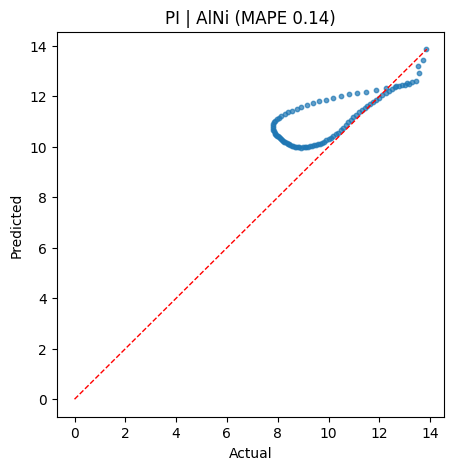

[PI] Left-out: AlNi | Test MAPE: 0.1415


In [ ]:
for name, df in [("PI", df_pi), ("EP", df_ep), ("Comp", df_comp), ("Random", df_rand)]:
    print("test")
    mean_mape, mapes, per_sys = run_loop(df, name, epochs=100, batch_size=128, lr=1e-3, device=device)
    print(f"{name} mean MAPE: {mean_mape:.4f}")
    #plot_pred_vs_actual(per_sys, n=6)
    #plot_error_hist(per_sys)

CUDA available: True
Device used: cuda
Model device: cuda:0
X_train device: cuda:0
y_train device: cuda:0
[PI] AlNi | Epoch 10/50  Loss: 3.5242
[PI] AlNi | Epoch 20/50  Loss: 3.0831
[PI] AlNi | Epoch 30/50  Loss: 2.7333
[PI] AlNi | Epoch 40/50  Loss: 2.5394
[PI] AlNi | Epoch 50/50  Loss: 2.3229


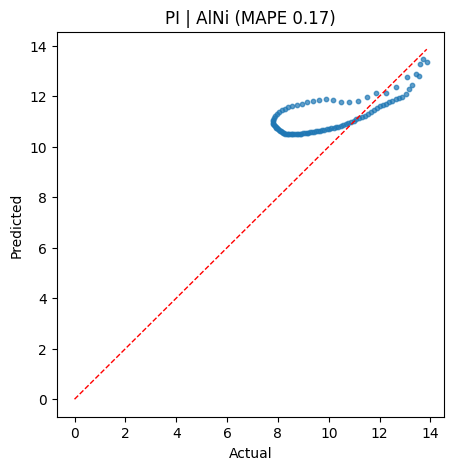

[PI] Left-out: AlNi | Test MAPE: 0.1672
CUDA available: True
Device used: cuda
Model device: cuda:0
X_train device: cuda:0
y_train device: cuda:0
[PI] CuMg | Epoch 10/50  Loss: 3.4131
[PI] CuMg | Epoch 20/50  Loss: 2.9458
[PI] CuMg | Epoch 30/50  Loss: 2.5512
[PI] CuMg | Epoch 40/50  Loss: 2.3978
[PI] CuMg | Epoch 50/50  Loss: 2.1705


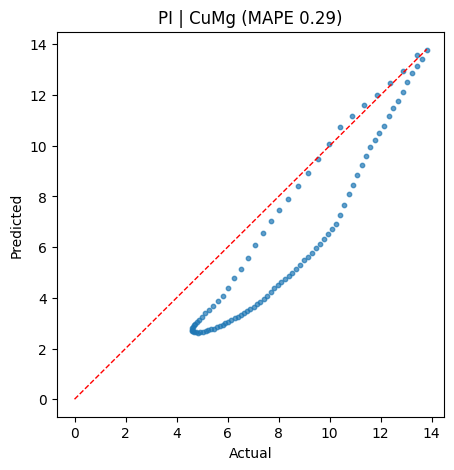

[PI] Left-out: CuMg | Test MAPE: 0.2932
CUDA available: True
Device used: cuda
Model device: cuda:0
X_train device: cuda:0
y_train device: cuda:0
[PI] NiMg | Epoch 10/50  Loss: 3.4382
[PI] NiMg | Epoch 20/50  Loss: 3.0298
[PI] NiMg | Epoch 30/50  Loss: 2.5692
[PI] NiMg | Epoch 40/50  Loss: 2.3360
[PI] NiMg | Epoch 50/50  Loss: 2.3246


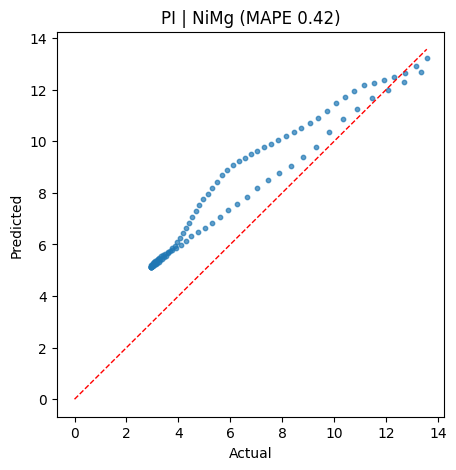

[PI] Left-out: NiMg | Test MAPE: 0.4246
CUDA available: True
Device used: cuda
Model device: cuda:0
X_train device: cuda:0
y_train device: cuda:0
[PI] AlTi | Epoch 10/50  Loss: 3.4036
[PI] AlTi | Epoch 20/50  Loss: 3.0485
[PI] AlTi | Epoch 30/50  Loss: 2.7205
[PI] AlTi | Epoch 40/50  Loss: 2.5047
[PI] AlTi | Epoch 50/50  Loss: 2.3793


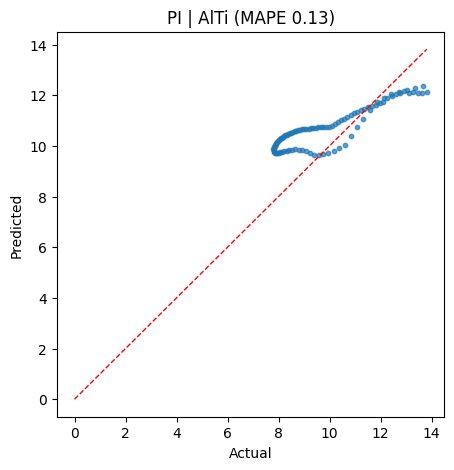

[PI] Left-out: AlTi | Test MAPE: 0.1338
CUDA available: True
Device used: cuda
Model device: cuda:0
X_train device: cuda:0
y_train device: cuda:0


KeyboardInterrupt: 

In [37]:
pi_mean_mape, pi_mapes, pi_per_sys = run_loop(df_pi, "PI", epochs=50, batch_size=32, lr=1e-3, device=device)

In [ ]:
ep_mean_mape, ep_mapes, ep_per_sys = run_loop(df_ep, "EP", epochs=50, batch_size=32, lr=1e-3)

In [ ]:
comp_mean_mape, comp_mapes, comp_per_sys = run_loop(df_comp, "Comp", epochs=50, batch_size=32, lr=1e-3)

In [ ]:
rand_mean_mape, rand_mapes, rand_per_sys = run_loop(df_rand, "Random", epochs=50, batch_size=32, lr=1e-3)